In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

sns.set()
# %config InlineBackend.figure_format = "svg"

In [2]:
dataset_path = "Electric_Production.csv"

In [3]:
df = pd.read_csv(dataset_path)
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [4]:
df = df.rename(columns={"DATE": "date", "Value": "value"})
df["date"] = pd.to_datetime(df["date"], format="%m-%d-%Y")
df = df.set_index("date").asfreq("MS")
df.head()

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### ADF Test

In [5]:
X = df["value"].to_numpy()

adf_result = adfuller(X)

print("Augmented Dickey-Fuller")
print(f"Statistical Test: {adf_result[0]:.4f}")
print(f"P-Value: {adf_result[1]:.4f}")
print("Critical Values")
for k, v in adf_result[4].items():
    print(f"\t{k}: {v:.4f}")

Augmented Dickey-Fuller
Statistical Test: -2.2570
P-Value: 0.1862
Critical Values
	1%: -3.4476
	5%: -2.8692
	10%: -2.5708


### Turn into stationary TS

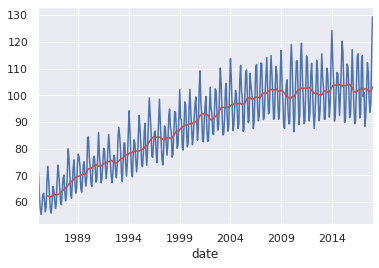

In [6]:
ma = df.rolling(12).mean()

fig, ax = plt.subplots()
df.plot(ax=ax, legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.show()

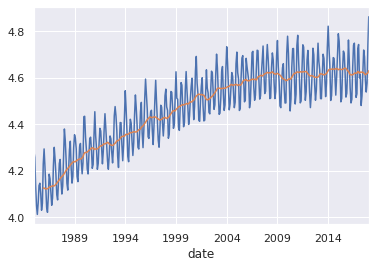

In [7]:
df_log = np.log(df)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False)
plt.show()

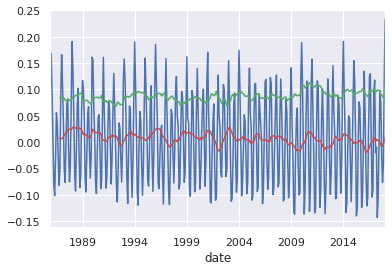

In [8]:
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots()
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color="r", legend=False)
std_sub.plot(ax=ax, color="g", legend=False)
plt.show()

#### Applying ADF to df_sub

In [9]:
X_sub = df_sub["value"].to_numpy()

adf_result_sub = adfuller(X_sub)

print("Augmented Dickey-Fuller")
print(f"Statistical Test: {adf_result_sub[0]:.4f}")
print(f"P-Value: {adf_result_sub[1]:.4e}")
print("Critical Values")
for k, v in adf_result_sub[4].items():
    print(f"\t{k}: {v:.4f}")

Augmented Dickey-Fuller
Statistical Test: -5.2116
P-Value: 8.3256e-06
Critical Values
	1%: -3.4481
	5%: -2.8694
	10%: -2.5709


### Differencing

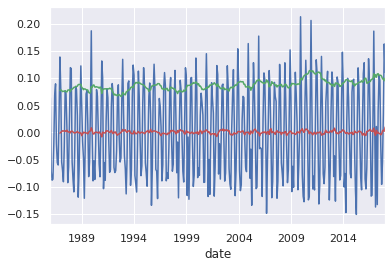

In [10]:
df_diff = df_sub.diff().dropna()
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

fig, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, color="r", legend=False)
std_diff.plot(ax=ax, color="g", legend=False)
plt.show()

In [11]:
X_diff = df_diff["value"].dropna().to_numpy()

adf_result_diff = adfuller(X_diff)

print("Augmented Dickey-Fuller")
print(f"Statistical Test: {adf_result_diff[0]:.4f}")
print(f"P-Value: {adf_result_diff[1]:.4e}")
print("Critical Values")
for k, v in adf_result_diff[4].items():
    print(f"\t{k}: {v:.4f}")

Augmented Dickey-Fuller
Statistical Test: -7.6511
P-Value: 1.7881e-11
Critical Values
	1%: -3.4483
	5%: -2.8694
	10%: -2.5710


## Forecasting by ARIMA (p, d, q)

AR: Auto regression

I: Integrated

MA: Moving Average

In [12]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_diff.dropna(), nlags=25) #autocorrelation
lag_pacf = pacf(df_diff.dropna(), nlags=25) #partial autocorrelation

/home/henrique/Documents/data-science-school/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


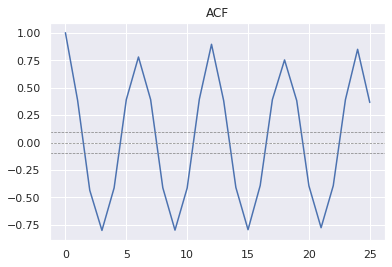

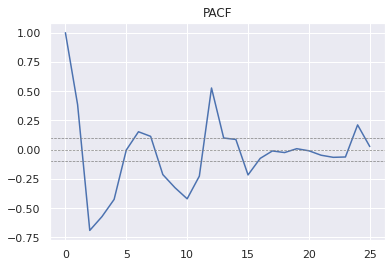

In [13]:
#Plot ACF and PACF
#1.96/np.sqrt(N-d)
#N --> number of points in dataset
#d --> number of times that differecing was applied

plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=-1.96 / np.sqrt((len(df_diff) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / np.sqrt((len(df_diff) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.title("ACF")
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=-1.96 / np.sqrt((len(df_diff) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / np.sqrt((len(df_diff) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.title("PACF")
plt.show()

In [14]:
#q --> x-axis value when the ACF curve crosses for the first time the upper line
#p --> x-axis value when the PACF curve crosses for the first time the upper line
#order = (p, q, d)
order = 2, 1, 2

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=order)
result_AR = model.fit(disp=-1)

/home/henrique/Documents/data-science-school/.venv/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/henrique/Documents/data-science-school/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarni

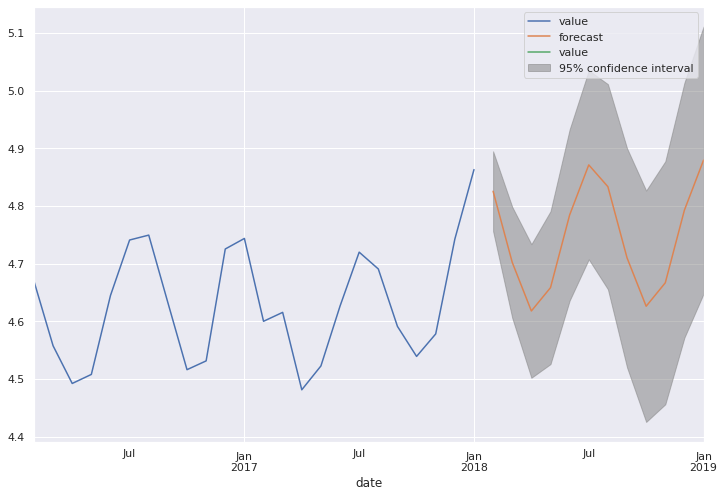

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
df_log[(df_log.index > "2016-01-01") & (df_log.index < "2018-02-01")].plot(ax=ax)
result_AR.plot_predict(start="2018-02-01", end="2019-01-01", ax=ax)
plt.show()